2021-09-17 15:00:11.752286: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-17 15:00:11.752404: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


11493376/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


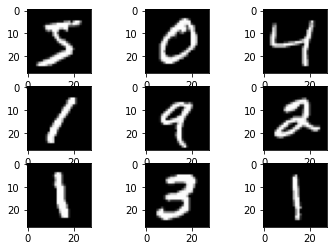

In [1]:
# example of loading the mnist dataset
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [2]:
# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

In [3]:
# one hot encode target values
from tensorflow.keras.utils import to_categorical
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [4]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [5]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

2021-09-17 15:00:19.633673: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-17 15:00:19.636559: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-17 15:00:19.636599: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-17 15:00:19.636626: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7649c5d320c3): /proc/driver/nvidia/version does not exist
2021-09-17 15:00:19.637046: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

> 98.558
> 98.683
> 98.550
> 98.858
> 98.750


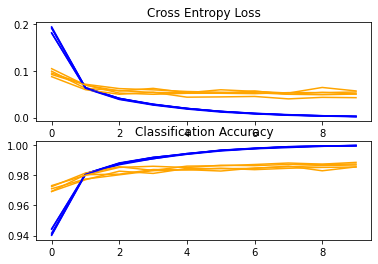

Accuracy: mean=98.680 std=0.117, n=5


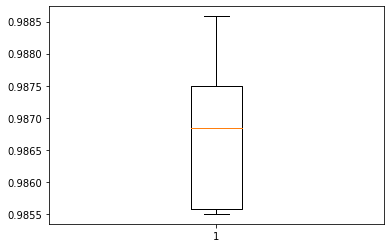

In [6]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
 
# entry point, run the test harness
run_test_harness()

In [7]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

> 98.550
> 98.558
> 98.708
> 98.825
> 98.800


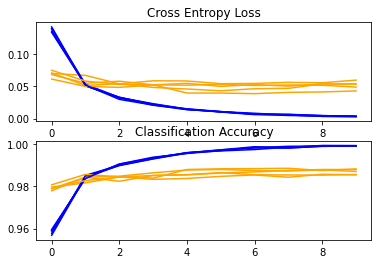

Accuracy: mean=98.688 std=0.116, n=5


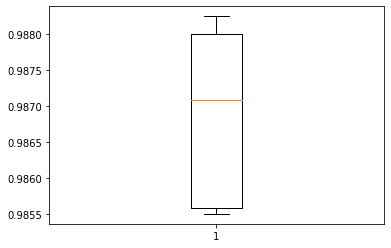

In [8]:
# cnn model with batch normalization for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
 
# entry point, run the test harness
run_test_harness()

In [9]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

> 98.867
> 98.700
> 98.958
> 99.292
> 99.017


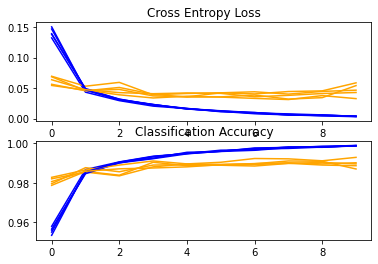

Accuracy: mean=98.967 std=0.195, n=5


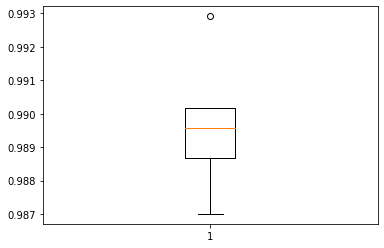

In [10]:
# deeper cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
 
# entry point, run the test harness
run_test_harness()

In [11]:
# fit model
model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

NameError: name 'model' is not defined

In [ ]:
# save the final model to file
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
	# save model
	model.save('final_model.h5')
 
# entry point, run the test harness
run_test_harness()

In [ ]:
# evaluate the deep model on the test dataset
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# load model
	model = load_model('final_model.h5')
	# evaluate model on test dataset
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
 
# entry point, run the test harness
run_test_harness()

In [ ]:
# make a prediction for a new image.
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
 
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, grayscale=True, target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 28, 28, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img
 
# load an image and predict the class
def run_example():
	# load the image
	img = load_image('sample_image.png')
	# load model
	model = load_model('final_model.h5')
	# predict the class
	digit = model.predict_classes(img)
	print(digit[0])
 
# entry point, run the example
run_example()

In [ ]:
print("Complete")